In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cirs = np.load('cirs_noised_ld.npy')
cirs_obs = np.load('cirs_observation_ld.npy')
triplets = np.load('triplets_ld.npy')

In [28]:
miu, sigma = cirs.mean(), cirs.var()

cirs = (cirs - cirs.min()) / (cirs.max() - cirs.min())
cirs_obs = (cirs_obs - cirs_obs.min()) / (cirs_obs.max() - cirs_obs.min())

In [69]:
P = np.array([cirs_obs[trp[0]] for trp in triplets])
Pi = np.array([cirs[trp[1]] for trp in triplets])
Pj = np.array([cirs[trp[2]] for trp in triplets])

In [29]:
def loss_hinge(p, pi, pj, W, margin=1):
    return max(0, margin - p.T @ W @ pi + p.T @ W @ pj)

def loss_global(triplets, W, cirs, cirs_obs):
    return np.sum([loss_hinge(cirs_obs[i0], cirs[i1], cirs[i2], W) for i0, i1, i2 in triplets])

def gradient(W, P, Pi, Pj):
    grad = np.zeros_like(W)

def gradient_descent():
    ...

## Online Algorithm for Scalable Image Similarity

In [74]:
C = 1000
margin = 1e4
n, d = cirs.shape # number of samples, dimension of samples
theta = np.ones((d, d)) 

In [ ]:
loss = [loss_0]

for ind_0, ind_1, ind_2 in t:
    p, pi, pj = c_o[ind_0], c[ind_1], c[ind_2]
    v = p * (pi - pj)
    tau = min(C, loss_hinge(p, pi, pj, theta, margin) / (v.T @ v))
    theta = theta + tau * v
    loss.append(loss_global(triplets, theta, cirs, cirs_obs))

In [60]:
loss_hinge(p, pi, pj, theta, margin) / (v.T @ v)
loss_hinge(p, pi, pj, theta, margin)

0

## Triplet loss with Keras

In [77]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense
from tensorflow.keras.layers import Lambda, Dot
from tensorflow.keras.regularizers import l2


In [387]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers


def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred)


class MarginLoss(layers.Layer):

    def __init__(self, margin=1.):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        diff = neg_pair_similarity - pos_pair_similarity
        print(diff)
        return tf.maximum(diff + self.margin, 0.)


class TripletModel(Model):
    def __init__(self, n_observation, n_comparison, margin=1., l2_reg=None):
        super().__init__(name="TripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        self.obs_layer = Input((n_observation, ), name='observation layer')
        # self.obs_layer = Embedding(n_observation, n_observation,
        #                             input_length=n_observation,
        #                             input_shape=(n_observation,),
        #                             name='obs_embedding',
        #                             embeddings_regularizer=l2_reg)
        self.comp_layer = Input((n_comparison, ), name='comparisons layer')

        # self.comp_layer = Embedding(n_comparison, n_comparison,
        #                             input_length=n_comparison,
        #                             input_shape=(n_comparison,),
        #                             name='comp_embedding',
        #                             embeddings_regularizer=l2_reg)

        self.dot = Dot(axes=1, normalize=True)

        self.margin_loss = MarginLoss(margin)
        
    def call(self, inputs, training=False):
        observation = inputs[0]
        pos_compare = inputs[1]
        neg_compare = inputs[2]
        
        obs_input = self.obs_layer(observation)
        
        pos_input = self.comp_layer(pos_compare)
        
        neg_input = self.comp_layer(neg_compare)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([obs_input, pos_input])
        neg_similarity = self.dot([obs_input, neg_input])
                
        return self.margin_loss([pos_similarity, neg_similarity])
    

def average_roc_auc(model, data_train, data_test):
    """Compute the ROC AUC for each user and average over users"""
    max_user_id = max(data_train['user_id'].max(),
                      data_test['user_id'].max())
    max_item_id = max(data_train['item_id'].max(),
                      data_test['item_id'].max())
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = data_train[data_train['user_id'] == user_id]
        pos_item_test = data_test[data_test['user_id'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_ids = np.arange(1, max_item_id + 1)
        items_to_rank = np.setdiff1d(
            all_item_ids, pos_item_train['item_id'].values)
        
        # Ground truth: return 1 for each item positively present in
        # the test set and 0 otherwise.
        expected = np.in1d(
            items_to_rank, pos_item_test['item_id'].values)
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)

            predicted = model.predict(
                [repeated_user_id, items_to_rank], batch_size=4096)
        
            user_auc_scores.append(roc_auc_score(expected, predicted))

    return sum(user_auc_scores) / len(user_auc_scores)

In [321]:
def sample_triplets(triplets, cir_obs, cir_base, random_seed=0):
    obs, pos_comp, neg_comp = [], [], []
    rng = np.random.RandomState(random_seed)
    for i, j, _ in triplets:
        obs.append(cir_obs[i])
        pos_comp.append(cir_base[j])

    neg_comp = cir_base[rng.randint(low=0, high=len(cirs), size=len(triplets))]

    return [np.array(obs), np.array(pos_comp), np.array(neg_comp)]

In [173]:
a, b, c = triplet_inputs
new_trip = [np.transpose(a), np.transpose(b), np.transpose(c)]

In [257]:
np.shape(triplet_inputs), np.shape(fake_y), np.shape(new_trip), np.shape(new_triplets)

((3, 400, 675), (400,), (3, 675, 400), (400, 3, 675))

In [309]:
latent_dim = 64
dim_comp

675

In [401]:
class TripletModel(Model):
    def __init__(self, n_observation, n_comparison, margin=1., latent_dim=64, l2_reg=None):
        super().__init__(name="TripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        # self.obs_layer = Input((n_observation, ), name='observation layer')
        self.obs_layer = Embedding(n_observation, n_observation,
                                    name='obs_embedding',
                                    embeddings_regularizer=l2_reg)
        # self.comp_layer = Input((n_comparison, ),name='comparisons layer')
        self.comp_layer = Embedding(n_comparison, n_comparison,
                            name='comp_embedding',
                            embeddings_regularizer=l2_reg)

        self.dot = Dot(axes=1, normalize=True)

        self.margin_loss = MarginLoss(margin)

        self.dense = Dense(latent_dim, activation='relu')
        
    def call(self, inputs, training=False):
        observation = inputs[0]
        pos_compare = inputs[1]
        neg_compare = inputs[2]
        
        obs_input = self.obs_layer(observation)
        
        pos_input = self.comp_layer(pos_compare)
        
        neg_input = self.comp_layer(neg_compare)

        # latent feature
        obs = self.dense(obs_input)
        pos = self.dense(pos_input)
        neg = self.dense(neg_input)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([obs, pos])
        neg_similarity = self.dot([obs, neg])
                
        return self.margin_loss([pos_similarity, neg_similarity])

In [371]:
from keras.callbacks import History 
history = History()

In [407]:
triplet_model.summary()

Model: "TripletModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 obs_embedding (Embedding)   multiple                  455625    
                                                                 
 comp_embedding (Embedding)  multiple                  455625    
                                                                 
 dot_64 (Dot)                multiple                  0         
                                                                 
 margin_loss_64 (MarginLoss)  multiple                 0         
                                                                 
 dense_56 (Dense)            multiple                  43264     
                                                                 
Total params: 954,514
Trainable params: 954,514
Non-trainable params: 0
_________________________________________________________________


In [405]:
fake_y = np.ones(len(cirs))

dim_obs = cirs_obs.shape[1]
dim_comp = cirs.shape[1]

triplet_model = TripletModel(dim_obs, dim_comp, l2_reg=1e-6)

triplet_model.compile(loss=identity_loss, optimizer="adam")

n_epochs = 100
batch_size = 64

for i in range(n_epochs):
    # Sample new negatives to build different triplets at each epoch
    triplet_inputs = sample_triplets(triplets, cirs_obs, cirs, random_seed=i)

    # Fit the model incrementally by doing a single pass over the
    # sampled triplets.
    triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                      batch_size=64, epochs=1, callbacks=[history])

Tensor("TripletModel/margin_loss_64/sub:0", shape=(None, 64, 64), dtype=float32)
Tensor("TripletModel/margin_loss_64/sub:0", shape=(None, 64, 64), dtype=float32)
7/7 [==============================] - 3s 474ms/step - loss: 1.0000


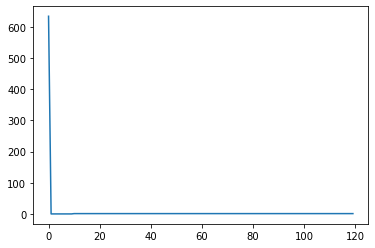

In [406]:
plt.plot(history.history['loss'])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
import numpy as np

# Generate dummy data
num_samples = 400
input_shape = (675,)
X1 = np.random.rand(num_samples, *input_shape)
X2 = np.random.rand(num_samples, *input_shape)
X3 = np.random.rand(num_samples, *input_shape)
Y = np.random.rand(num_samples, 1)

# Define the model
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)
input3 = Input(shape=input_shape)

x = Dense(128, activation='relu')(input1)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

y = Dense(128, activation='relu')(input2)
y = Dense(64, activation='relu')(y)
y = Dense(32, activation='relu')(y)

z = Dense(128, activation='relu')(input3)
z = Dense(64, activation='relu')(z)
z = Dense(32, activation='relu')(z)

merged = layers.concatenate([x, y, z])
output = Dense(1)(merged)

model = Model(inputs=[input1, input2, input3], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit([X1, X2, X3], Y, batch_size=32, epochs=100, validation_split=0.2)

# Evaluate the model on test data
test_loss = model.evaluate([X1, X2, X3], Y)
print("Test loss:", test_loss)


In [398]:
from keras.layers import Input, Dense
from keras.models import Model

class Trip(Model):
    def __init__(self):
        super(Trip, self).__init__()
        self.input1 = Input(shape=(675,))
        self.input2 = Input(shape=(675,))
        self.input3 = Input(shape=(675,))
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(32, activation='relu')
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x1 = self.input1(inputs[0])
        x2 = self.input2(inputs[1])
        x3 = self.input3(inputs[2])
        x = self.d1(x1)
        x = self.d2(x)
        x = self.output_layer(x)
        return x

# Create an instance of the Trip class
trip = Trip()

# Compile the model
trip.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Generate some sample data
import numpy as np
X1 = np.random.rand(400, 675)
X2 = np.random.rand(400, 675)
X3 = np.random.rand(400, 675)
y = np.random.randint(0, 2, size=(400, 1))

# Train the model
trip.fit([X1, X2, X3], y, epochs=10, batch_size=32)


Epoch 1/10


TypeError: in user code:

    File "d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\lenovo\AppData\Local\Temp\__autograph_generated_filexm3dzdu5.py", line 10, in tf__call
        x1 = ag__.converted_call(ag__.ld(self).input1, (ag__.ld(inputs)[0],), None, fscope)

    TypeError: Exception encountered when calling layer "trip_2" (type Trip).
    
    in user code:
    
        File "<ipython-input-396-ac53be10c660>", line 15, in call  *
            x1 = self.input1(inputs[0])
    
        TypeError: 'KerasTensor' object is not callable
    
    
    Call arguments received by layer "trip_2" (type Trip):
      • inputs=('tf.Tensor(shape=(None, 675), dtype=float32)', 'tf.Tensor(shape=(None, 675), dtype=float32)', 'tf.Tensor(shape=(None, 675), dtype=float32)')
